# Step 1 : Text Processing

## Import Libraries

In [132]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import operator
from textblob import TextBlob
from importlib import reload
import sys
from imp import reload

    
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

## Import Data

In [133]:
#file_path = "C:\\Users\\User\\Documents\\IST664 Final Project\\imdb_master.csv"
#meta = pd.read_csv(file_path, sep = '\t', header = None)

#Larger File
#df = pd.read_csv('C:\\Users\\User\\Documents\\IST664 Final Project\\imdb_master.csv',encoding="latin-1")

#smaller File
df = pd.read_csv('C:\\Users\\User\\Documents\\IST664 Final Project\\imdb_master2.csv',encoding="latin-1")

df.head()

,label,review
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs..."
1,neg,"Its No wonder this was free with the Mail on Sunday, slow going, poor acting, and filming (camera flare, near start of movie, is not even artistic) = Straight to video, but not in this case, why not recoup some of your (Film production costs) by releasing it free with a UK Sunday newspaper, at l..."
2,neg,"The only Riddle in this film was how it ever got made. the British film Industry needs to make films people actually want to watch and not look to get Taxpayers money (a'la BBC) to keep Luvvies in their life style they have been accustomed to, with doing nothing for it.<br /><br />the Film was e..."
3,neg,"It doesn't surprise me that the makers of this hopeless movie couldn't find a UK distributor, and then had to release it as a free DVD with a Sunday newspaper. The distributors could clearly see what the film-makers and the Sunday newspaper couldn't, that this was one movie that just wasn't goin..."
4,neg,"I could not believe the original rating I found when i looked up this film, 9.5? Unfortunately it looks like I am not alone.<br /><br />The film, is slow and boring really, one of the sad things is that if the film had been given a realistic rating of around 5 or 6 then the expectation would not..."


## Data Exploration and Cleaning

In [134]:
#Function to count and summarize categories
def class_counts(df, label='label'):
    return df[label].value_counts().to_string(header=None)

print(class_counts(df))

pos      7778
neg      6909
unsup    2488


## Text Cleaning

In [135]:
import string
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    #repmoves all line breaks
    #text = string.replace("\r","")
    text = text.rstrip("\r\n")
    text = text.rstrip("\r")
    text = text.rstrip("\n")
    
    return text

df['clean_rev'] = df['review'].apply(lambda x: clean_text(x))
df.head(1)

,label,review,clean_rev
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",this movie should have been called the eyes of alexander and they should have done away with the bogart concept altogether the film started out with a lighthearted approach to bogarts legacy and some comical moments with his surgery oriented face but after the first minutes it morphs into a more...


## Spelling Correction

In [136]:
# spelling correction
from textblob import TextBlob
df['clean_rev'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    this movie should have been called the eyes of alexander and they should have done away with the bogart concept altogether the film started out with a lighthearted approach to bogart legacy and some comical moments with his surgery tormented face but after the first minutes it months into a more...
1    its no wonder this was free with the mail on sunday slow going poor acting and filling camera flare near start of movie is not even artistic straight to video but not in this case why not record some of your film production costs by releasing it free with a up sunday newspaper at least this way ...
2    the only riddle in this film was how it ever got made the british film industry needs to make films people actually want to watch and not look to get taxpayers money all bc to keep navvies in their life style they have been accustomed to with doing nothing for it br br the film was every thing w...
3    it doesn surprise me that the makers of this hopeless movie couldn find a up dis

In [137]:
df[['review', 'clean_rev']].sample(3)

,review,clean_rev
13560,"To suggest Anton Newcombe of the Brian Jonestown Massacre could also use some therapy is putting it mildly. In Dig! which won the Grand Jury Prize at Sundance, we watch him and his band self-sabotage over seven years, while ex-friends and contemporaries The Dandy Warhols rise to comparative grea...",to suggest anton newcombe of the brian jonestown massacre could also use some therapy is putting it mildly in dig which won the grand jury prize at sundance we watch him and his band self sabotage over seven years while ex friends and contemporaries the dandy warhols rise to comparative greatnes...
5645,"After watching this, I had lost a little respect for Christopher Lee (This has passed over time). This film was utter garbage. First, they tried to recreate the ending from the first ""Howling,"" with incredibly bad make-up. Then they try to turn it into a sad excuse of a werewolf porn film! The p...",after watching this i had lost a little respect for christopher lee this has passed over time this film was utter garbage first they tried to recreate the ending from the first howling with incredibly bad make up then they try to turn it into a sad excuse of a werewolf porn film the plot sucks a...
9732,"Murder in Mesopotamia, I have always considered one of the better Poirot books, as it is very creepy and has an ingenious ending. There is no doubt that the TV adaptation is visually striking, with some lovely photography and a very haunting music score. As always David Suchet is impeccable as H...",murder in mesopotamia i have always considered one of the better poirot books as it is very creepy and has an ingenious ending there is no doubt that the tv adaptation is visually striking with some lovely photography and a very haunting music score as always david suchet is impeccable as hercul...


## Explore Word Frequncy - 

In [138]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

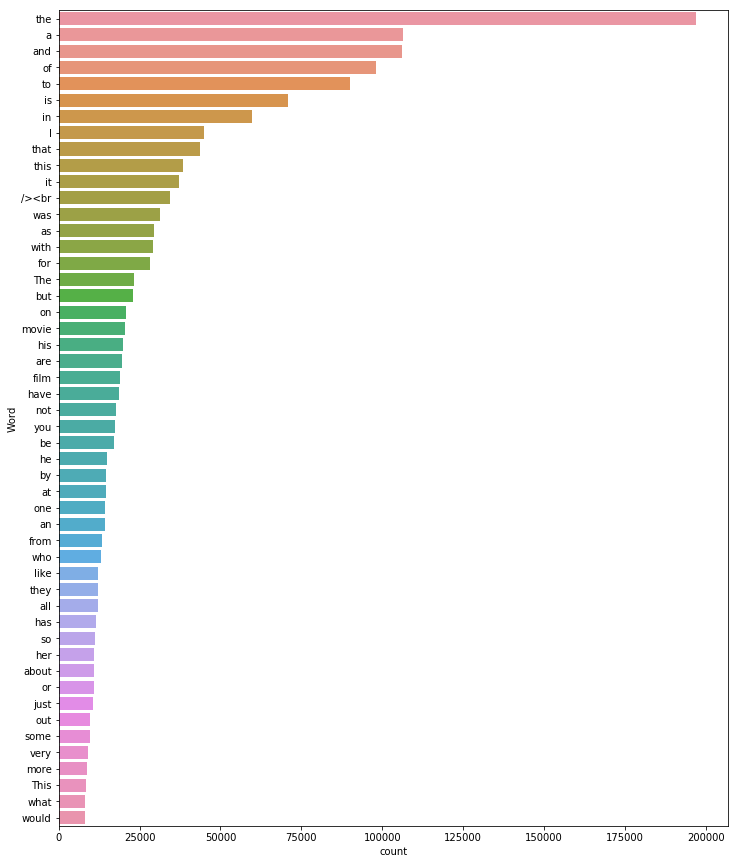

In [139]:
# print 100 most frequent words
freq_words(df['review'], 50)

## Filtering Stopwords

In [140]:
import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

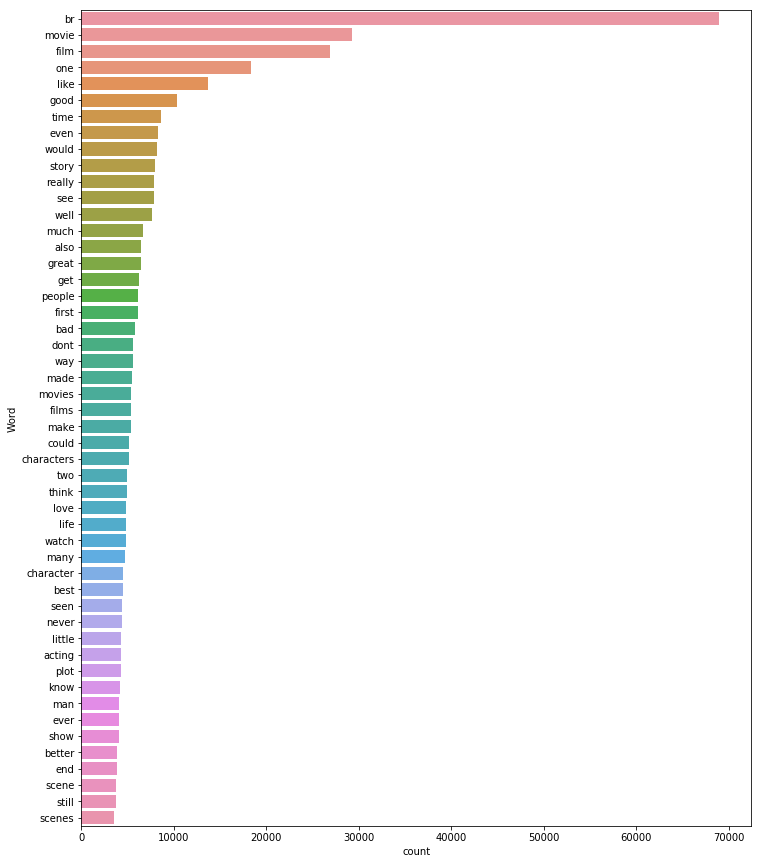

In [141]:
import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#from nltk.corpus import stopwords
#nltkstopwords = nltk.corpus.stopwords.words('english')
#morestopwords = ['_',"br","it.", "It's",
#                 'It',"|",'y',"'s","'d","'ll","'t","'m","'re","'ve", "n't"]
#stopwords = nltkstopwords + morestopwords


# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['clean_rev'] = df['clean_rev'].apply(lambda x: remove_stopwords(x))
freq_words(df['clean_rev'], 50)

In [142]:
df.head(1)

,label,review,clean_rev
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...


# Step 2 : Feature Engineering

## Bag-of-Words Tokenization BOW

In [143]:
#from sklearn.feature_extraction.text import CountVectorizer

# create the transform
#vectorizer = CountVectorizer()
# tokenize and build vocab
#vectorizer.fit(df['clean_rev'])
# summarize
#print(vectorizer.vocabulary_)

In [144]:
# encode document
#vector = vectorizer.transform(df['clean_rev'])
# summarize encoded vector
#print(vector.shape)
#print(type(vector))
#print(vector.toarray())

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['clean_rev'])

## NLTK Baive Bayes

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['label'], test_size=0.3, random_state=1)

In [147]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
#print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

print('accuracy %s' % accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

accuracy 0.7939064622549971
              precision    recall  f1-score   support

         neg       0.78      0.89      0.83      2067
         pos       0.80      0.86      0.83      2330
       unsup       0.87      0.34      0.49       756

   micro avg       0.79      0.79      0.79      5153
   macro avg       0.82      0.70      0.72      5153
weighted avg       0.80      0.79      0.78      5153



## TF_IDF Features

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['clean_rev'])

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['label'], test_size=0.3, random_state=123)

In [150]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

accuracy 0.7533475645255191
              precision    recall  f1-score   support

         neg       0.85      0.81      0.83      2058
         pos       0.69      0.94      0.80      2348
       unsup       0.00      0.00      0.00       747

   micro avg       0.75      0.75      0.75      5153
   macro avg       0.51      0.58      0.54      5153
weighted avg       0.66      0.75      0.70      5153



# Step 3 : Experiments

In [151]:
df.head(1)

,label,review,clean_rev
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...


## Feature Engineering Continued

In [152]:
# Feature 1 : Word Count
#number of words
df['word_count'] = df['clean_rev'].apply(lambda x: len(str(x).split(" ")))
df[['clean_rev','word_count']].head()

,clean_rev,word_count
0,movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215
1,wonder free mail sunday slow going poor acting filming camera flare near start movie even artistic straight video case recoup film production costs releasing free uk sunday newspaper least way get captive audience recover costs br br given film due effort pull old actors shell nice see old faces...,74
2,riddle film ever got made british film industry needs make films people actually want watch look get taxpayers money ala bbc keep luvvies life style accustomed nothing br br film every thing wrong british films relied stereotypes london people either posh corrupt gangsters luvvies gawd blimey je...,115
3,doesnt surprise makers hopeless movie couldnt find uk distributor release free dvd sunday newspaper distributors could clearly see film makers sunday newspaper couldnt one movie wasnt going recoup costs br br since thriller riddles would helped theyd picked lead actor could enunciate properly ra...,216
4,could believe original rating found looked film unfortunately looks like alone br br film slow boring really one sad things film given realistic rating around expectation would high br br unfortunately case watching film seeing poor story acting left giving score br br vinnie jones superb lock s...,89


In [153]:
# Feature 2 : number of characters
df['char_count'] = df['clean_rev'].str.len() ## this also includes spaces
df[['clean_rev','char_count']].head()

,clean_rev,char_count
0,movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,1475
1,wonder free mail sunday slow going poor acting filming camera flare near start movie even artistic straight video case recoup film production costs releasing free uk sunday newspaper least way get captive audience recover costs br br given film due effort pull old actors shell nice see old faces...,443
2,riddle film ever got made british film industry needs make films people actually want watch look get taxpayers money ala bbc keep luvvies life style accustomed nothing br br film every thing wrong british films relied stereotypes london people either posh corrupt gangsters luvvies gawd blimey je...,731
3,doesnt surprise makers hopeless movie couldnt find uk distributor release free dvd sunday newspaper distributors could clearly see film makers sunday newspaper couldnt one movie wasnt going recoup costs br br since thriller riddles would helped theyd picked lead actor could enunciate properly ra...,1540
4,could believe original rating found looked film unfortunately looks like alone br br film slow boring really one sad things film given realistic rating around expectation would high br br unfortunately case watching film seeing poor story acting left giving score br br vinnie jones superb lock s...,560


In [154]:
# Feature 3 : avg word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['clean_rev'].apply(lambda x: avg_word(x))
df[['clean_rev','avg_word']].head()

,clean_rev,avg_word
0,movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,5.865116
1,wonder free mail sunday slow going poor acting filming camera flare near start movie even artistic straight video case recoup film production costs releasing free uk sunday newspaper least way get captive audience recover costs br br given film due effort pull old actors shell nice see old faces...,5.000000
2,riddle film ever got made british film industry needs make films people actually want watch look get taxpayers money ala bbc keep luvvies life style accustomed nothing br br film every thing wrong british films relied stereotypes london people either posh corrupt gangsters luvvies gawd blimey je...,5.365217
3,doesnt surprise makers hopeless movie couldnt find uk distributor release free dvd sunday newspaper distributors could clearly see film makers sunday newspaper couldnt one movie wasnt going recoup costs br br since thriller riddles would helped theyd picked lead actor could enunciate properly ra...,6.134259
4,could believe original rating found looked film unfortunately looks like alone br br film slow boring really one sad things film given realistic rating around expectation would high br br unfortunately case watching film seeing poor story acting left giving score br br vinnie jones superb lock s...,5.303371


In [155]:
# Feature 4 : Diversity_score i.e. Average length of words used in statement
df['diversity'] = df['char_count'] / df['word_count']
df.head(1) 

,label,review,clean_rev,word_count,char_count,avg_word,diversity
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465


In [156]:
#Feature 5 : Polarity
from textblob import TextBlob
df['polarity'] = df['clean_rev'].map(lambda text: TextBlob(text).sentiment.polarity)
df.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955


In [157]:
#Feature 6 : Chars without spaces
df["char_count_w/o_spaces"] = df["clean_rev"].apply(lambda x : len(x.replace(" ","")))
df.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261


## Experiment 1 

In [158]:
#df2 = df.drop(["review"], axis=1)
df2 = df
df2.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261


In [159]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvz = CountVectorizer()
cvz.fit(df["clean_rev"].values)
count_vectors = cvz.transform(df2["clean_rev"].values)

#Vectorizoer
word_tfidf =TfidfVectorizer(max_features=500)
word_tfidf.fit(df2["clean_rev"].values)
word_vectors_tfidf = word_tfidf.transform(df2["clean_rev"].values)


In [160]:
from scipy.sparse import hstack, csr_matrix

meta_features = ['word_count','char_count', 'avg_word','diversity','polarity','char_count_w/o_spaces'
                ]

feature_set1 = df2[meta_features]

train = hstack([word_vectors_tfidf, csr_matrix(feature_set1)], "csr")
train

<17175x506 sparse matrix of type '<class 'numpy.float64'>'
	with 840351 stored elements in Compressed Sparse Row format>

In [161]:
from sklearn.preprocessing import LabelEncoder 

target = df2['label'].values
target = LabelEncoder().fit_transform(target)

In [162]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train, target)
train_x.shape

(12881, 506)

In [163]:
val_x.shape

(4294, 506)

In [164]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix



## Log Regression

In [165]:
model = LogisticRegression()
model.fit(train_x, train_y)
preds = model.predict(val_x)
print('accuracy %s' % accuracy_score(preds, val_y))
print(classification_report(preds, val_y))

accuracy 0.7147182114578482
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1916
           1       0.85      0.68      0.75      2378
           2       0.00      0.00      0.00         0

   micro avg       0.71      0.71      0.71      4294
   macro avg       0.56      0.48      0.51      4294
weighted avg       0.84      0.71      0.77      4294



## Naive Bayes

In [166]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X = df['clean_rev']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7535416262371434
              precision    recall  f1-score   support

         neg       0.84      0.81      0.83      2060
         pos       0.70      0.94      0.80      2363
       unsup       0.00      0.00      0.00       730

   micro avg       0.75      0.75      0.75      5153
   macro avg       0.51      0.58      0.54      5153
weighted avg       0.66      0.75      0.70      5153



## Support Vector Machine

In [167]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7426741703861828
              precision    recall  f1-score   support

         neg       0.83      0.79      0.81      2060
         pos       0.69      0.93      0.79      2363
       unsup       1.00      0.00      0.00       730

   micro avg       0.74      0.74      0.74      5153
   macro avg       0.84      0.57      0.53      5153
weighted avg       0.79      0.74      0.69      5153



## Word to Vec

In [168]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8078789054919464
              precision    recall  f1-score   support

         neg       0.83      0.85      0.84      2060
         pos       0.81      0.87      0.84      2363
       unsup       0.70      0.50      0.58       730

   micro avg       0.81      0.81      0.81      5153
   macro avg       0.78      0.74      0.75      5153
weighted avg       0.80      0.81      0.80      5153



## Experiments 2 : Part A

### ...Even More Feature Engineering

In [169]:
df2.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261


## Lemmatization & POS Tagging

In [170]:
from nltk.stem.wordnet import WordNetLemmatizer

# text preprocessing 
lem = WordNetLemmatizer()

def clean_text(text):
    ## lower case 
    cleaned = text.lower()
    
    ## remove punctuations
    punctuations = string.punctuation
    cleaned = "".join(character for character in cleaned if character not in punctuations)
    
    ## remove stopwords 
    words = cleaned.split()
    stopword_lists = stopwords.words("english")
    cleaned = [word for word in words if word not in stopword_lists]
    
    ## normalization - lemmatization
    cleaned = [lem.lemmatize(word, "v") for word in cleaned]
    cleaned = [lem.lemmatize(word, "n") for word in cleaned]
    
    ## join 
    cleaned = " ".join(cleaned)
    return cleaned


In [171]:
df2["cleaned"] = df2["clean_rev"].apply(lambda x : clean_text(x))
df2.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces,cleaned
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261,movie call eye alexander do away bogart concept altogether film start lighthearted approach bogart legacy comical moment surgery orient face first minute morph serious thriller two palm size sapphire purportedly lay eye marble headpiece alexander great see right death gem great value quality siz...


## Part-of-Speech Tagging

In [172]:
pos_dic = {"noun" : ["NNP", "NN", "NNS", "NNPS"], "verb" : ["VBZ", "VB", "VBD","VBG", "VBN"]}
import nltk
def pos_check(txt, family):
    tags = nltk.pos_tag(nltk.word_tokenize(txt))
    count = 0
    for tag in tags:
        tag = tag[1]
        if tag in pos_dic[family]:
            count += 1 
    return count


In [173]:
# pos_check

df2["noun_count"] = df2["cleaned"].apply(lambda x : pos_check(x, "noun"))
df2["verb_count"] = df2["cleaned"].apply(lambda x : pos_check(x, "verb"))


In [174]:
df2.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces,cleaned,noun_count,verb_count
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261,movie call eye alexander do away bogart concept altogether film start lighthearted approach bogart legacy comical moment surgery orient face first minute morph serious thriller two palm size sapphire purportedly lay eye marble headpiece alexander great see right death gem great value quality siz...,113,20


In [175]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvz = CountVectorizer()
cvz.fit(df["cleaned"].values)
count_vectors = cvz.transform(df2["cleaned"].values)

#Vectorizoer
word_tfidf =TfidfVectorizer(max_features=500)
word_tfidf.fit(df2["cleaned"].values)
word_vectors_tfidf = word_tfidf.transform(df2["cleaned"].values)

In [176]:
from scipy.sparse import hstack, csr_matrix

meta_features = ['word_count','char_count', 'avg_word','diversity','polarity','char_count_w/o_spaces',
                'noun_count','verb_count']

feature_set1 = df2[meta_features]

train = hstack([word_vectors_tfidf, csr_matrix(feature_set1)], "csr")
train

<17175x508 sparse matrix of type '<class 'numpy.float64'>'
	with 964504 stored elements in Compressed Sparse Row format>

In [177]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder 

target = df2['label'].values
target = LabelEncoder().fit_transform(target)

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train, target)

In [178]:
model = LogisticRegression()
model.fit(train_x, train_y)
preds = model.predict(val_x)
print('accuracy %s' % accuracy_score(preds, val_y))
print(classification_report(preds, val_y))



accuracy 0.7314857941313461
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1859
           1       0.87      0.71      0.78      2435
           2       0.00      0.00      0.00         0

   micro avg       0.73      0.73      0.73      4294
   macro avg       0.57      0.49      0.53      4294
weighted avg       0.85      0.73      0.79      4294



In [179]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X = df['cleaned']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7517950708325247
              precision    recall  f1-score   support

         neg       0.84      0.81      0.82      2060
         pos       0.70      0.93      0.80      2363
       unsup       0.00      0.00      0.00       730

   micro avg       0.75      0.75      0.75      5153
   macro avg       0.51      0.58      0.54      5153
weighted avg       0.65      0.75      0.70      5153



In [180]:
model = svm.SVC()
model.fit(train_x, train_y)
preds = model.predict(val_x)
print('accuracy %s' % accuracy_score(preds, val_y))
print(classification_report(preds, val_y))

accuracy 0.47019096413600375
              precision    recall  f1-score   support

           0       0.38      0.44      0.41      1473
           1       0.69      0.49      0.57      2813
           2       0.00      0.00      0.00         8

   micro avg       0.47      0.47      0.47      4294
   macro avg       0.36      0.31      0.33      4294
weighted avg       0.58      0.47      0.51      4294



In [181]:
model = ensemble.ExtraTreesClassifier()
model.fit(train_x, train_y)
preds = model.predict(val_x)
print('accuracy %s' % accuracy_score(preds, val_y))
print(classification_report(preds, val_y))

accuracy 0.6532370749883558
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1945
           1       0.76      0.66      0.71      2271
           2       0.02      0.17      0.04        78

   micro avg       0.65      0.65      0.65      4294
   macro avg       0.51      0.50      0.48      4294
weighted avg       0.74      0.65      0.69      4294



In [182]:
import xgboost
model = xgboost.XGBClassifier()
model.fit(train_x, train_y)
preds = model.predict(val_x)
print('accuracy %s' % accuracy_score(preds, val_y))
print(classification_report(preds, val_y))

accuracy 0.6977177456916628
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1768
           1       0.85      0.67      0.75      2525
           2       0.00      1.00      0.00         1

   micro avg       0.70      0.70      0.70      4294
   macro avg       0.54      0.80      0.50      4294
weighted avg       0.82      0.70      0.75      4294



## Step 3 : Experiments Part B

In [183]:
df3 = df2
df3.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces,cleaned,noun_count,verb_count
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261,movie call eye alexander do away bogart concept altogether film start lighthearted approach bogart legacy comical moment surgery orient face first minute morph serious thriller two palm size sapphire purportedly lay eye marble headpiece alexander great see right death gem great value quality siz...,113,20


In [184]:
#N-Grams
ngram_tfidf =TfidfVectorizer(max_features=500, ngram_range=(1,2))
ngram_tfidf.fit(df3["cleaned"].values)
ngram_tfidf_tfidf = ngram_tfidf.transform(df3["cleaned"].values)

In [185]:
from scipy.sparse import hstack, csr_matrix

meta_features = ['word_count','char_count', 'avg_word','diversity','polarity','char_count_w/o_spaces',
                'noun_count','verb_count']

feature_set2 = df3[meta_features]

train2 = hstack([ngram_tfidf_tfidf, csr_matrix(feature_set2)], "csr")
train2

<17175x508 sparse matrix of type '<class 'numpy.float64'>'
	with 976324 stored elements in Compressed Sparse Row format>

In [186]:
from sklearn.preprocessing import LabelEncoder 

target2 = df2['label'].values
target2 = LabelEncoder().fit_transform(target2)

from sklearn.model_selection import train_test_split
train_x2, val_x2, train_y2, val_y2 = train_test_split(train, target)

In [187]:
model = LogisticRegression()
model.fit(train_x2, train_y2)
preds2 = model.predict(val_x2)
print('accuracy %s' % accuracy_score(preds2, val_y2))
print(classification_report(preds2, val_y2))

accuracy 0.727992547741034
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1859
           1       0.87      0.70      0.77      2435
           2       0.00      0.00      0.00         0

   micro avg       0.73      0.73      0.73      4294
   macro avg       0.56      0.49      0.52      4294
weighted avg       0.85      0.73      0.78      4294



In [188]:
model = svm.SVC()
model.fit(train_x2, train_y2)
preds2 = model.predict(val_x2)
print('accuracy %s' % accuracy_score(preds2, val_y2))
print(classification_report(preds2, val_y2))

accuracy 0.4527247321844434
              precision    recall  f1-score   support

           0       0.40      0.43      0.42      1623
           1       0.64      0.47      0.54      2670
           2       0.00      0.00      0.00         1

   micro avg       0.45      0.45      0.45      4294
   macro avg       0.35      0.30      0.32      4294
weighted avg       0.55      0.45      0.49      4294



In [189]:
model = ensemble.ExtraTreesClassifier()
model.fit(train_x2, train_y2)
preds2 = model.predict(val_x2)
print('accuracy %s' % accuracy_score(preds2, val_y2))
print(classification_report(preds2, val_y2))

accuracy 0.6443875174662319
              precision    recall  f1-score   support

           0       0.77      0.65      0.71      2036
           1       0.73      0.65      0.69      2182
           2       0.02      0.20      0.04        76

   micro avg       0.64      0.64      0.64      4294
   macro avg       0.51      0.50      0.48      4294
weighted avg       0.73      0.64      0.69      4294



In [190]:
import xgboost
model = xgboost.XGBClassifier()
model.fit(train_x2, train_y2)
preds2 = model.predict(val_x2)
print('accuracy %s' % accuracy_score(preds2, val_y2))
print(classification_report(preds2, val_y2))

accuracy 0.6939916162086632
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1778
           1       0.85      0.66      0.75      2516
           2       0.00      0.00      0.00         0

   micro avg       0.69      0.69      0.69      4294
   macro avg       0.54      0.47      0.50      4294
weighted avg       0.81      0.69      0.75      4294



## NLTK (NO Sci Kit Learn Vectorizers)

In [191]:
df4 = df3
df4.head(1)

,label,review,clean_rev,word_count,char_count,avg_word,diversity,polarity,char_count_w/o_spaces,cleaned,noun_count,verb_count
0,neg,"This movie should have been called ""The Eyes of Alexander"", and they should have done away with the Bogart concept altogether. The film started out with a lighthearted approach to Bogart's legacy and some comical moments with his surgery oriented face, but after the first 15-30 minutes it morphs...",movie called eyes alexander done away bogart concept altogether film started lighthearted approach bogarts legacy comical moments surgery oriented face first minutes morphs serious thriller two palm size sapphires purportedly laid eyes marble headpiece alexander great seen right death gems great...,215,1475,5.865116,6.860465,0.288955,1261,movie call eye alexander do away bogart concept altogether film start lighthearted approach bogart legacy comical moment surgery orient face first minute morph serious thriller two palm size sapphire purportedly lay eye marble headpiece alexander great see right death gem great value quality siz...,113,20


## Appendex Tested Code

In [192]:
#common word removal

freq = pd.Series(' '.join(df2['clean_plot']).split()).value_counts()[:10]
freq

freq = list(freq.index)
df2['clean_plot'] = df2['clean_plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df2['clean_plot'].head()

KeyError: 'clean_plot'

In [ ]:
#rare word Removal
freq = pd.Series(' '.join(df2['clean_plot']).split()).value_counts()[-10:]
freq

freq = list(freq.index)
df2['clean_plot'] = df2['clean_plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df2['clean_plot'].head()

In [ ]:
#Feature-9: Count of Title case words.
df2['Feature_9'] = df2["clean_plot"].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.istitle() == True]) )


In [ ]:
# words which START WITH or END WITH particular characters. 
import operator

starting_words = sorted(list(map(lambda word : word[:2],filter(lambda word : len(word) > 3,all_text_without_sw.split()))))
sw_counts = Counter(starting_words)
top_30_sw = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])

#Feature-10: Count of (Most words start with)
df2['Feature_10'] = df2["clean_plot"].apply(lambda x: len([w for w in str(x).lower().split() if w[:2] in top_30_sw and w not in stop_words]) )



In [ ]:
#Feature-11: Count of (Most words end with)
ending_words = sorted(list(map(lambda word : word[-2:],filter(lambda word : len(word) > 3,all_text_without_sw.split()))))
ew_counts = Counter(ending_words)
top_30_ew = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])
df2['Feature_11'] = df2["clean_plot"].apply(lambda x: len([w for w in str(x).lower().split() if w[:2] in top_30_ew and w not in stop_words]) )


In [ ]:
#getting top 50 used words:
all_text_without_sw = ''
for i in df2.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.clean_plot)
#getting counts of each words:
counts = Counter(re.findall(r"[\w']+", all_text_without_sw))
#deleting ' from counts
del counts["'"]
#getting top 50 used words:
sorted_x = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True)[:50])

#Feature-5: The count of top used words.
df2['Feature_5'] = df2["clean_plot"].apply(lambda x: len([w for w in str(x).lower().split() if w in sorted_x]) )
